# FWI Example
We will peform FWI using the following steps:
1. Prepare models
    * Read the true model from binary file
    * Generate our subsampled true and initial models 
2. Build a small local compute cluster (2 workers) 
3. Create list of shot locations 
4. Build F, the distributed block operator for seismic modeling
5. Use F to create data for both models
6. Visualize data
7. Assess if data is cycle skipped at the farthest offsets
8. Build the gradient and cost functions
9. Perform the FWI using optim.jl
10. Visualize velocity models and objection function
11. Visualize data match 
12. Write models to local disk
13. Remove local files and workers

#### Note on runtime
This notebook takes approximately 1 hour to run for 12 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

## Add required packages
Uncomment the line below if you need to add these packages to your environment

In [1]:
# ]add Optim LineSearches

## Record time for start of notebook

In [2]:
time_beg = time()

1.602799279375933e9

In [3]:
using PyPlot, Distributed, Jets, JetPack, JetPackDSP, Printf

## 1. Prepare models

#### Read true model from binary file

In [4]:
v = read!("../20_marmousi_model_setup/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));

#### Subsample models
We will resample from the 20m grid to a 40m grid

In [5]:
v = v[1:2:end,1:2:end]

dz,dx = 40.0,40.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (40.0, 40.0)
(nz, nx) = (88, 426)


#### Smooth the true model to generate true and initial models
Note that we will perform this example at low frequency, and so we smooth both the true and the initial models before we begin. 

Please refer to the smoothing notebook in the `20_marmousi_model_setup` example directory for more details on our smoothing approach. Note that we apply the smoothing in slowness to preserve traveltime.

In [6]:
# smoothing for the true model
ns1 = 1
P1 = JopPad(JetSpace(Float32,nz,nx), -ns1:nz+ns1, -ns1:nx+ns1, extend=true)
S1 = JopConvolve(range(P1), smoother=:rect, n=(ns1,ns1))
R1 = JopPad(JetSpace(Float32,nz,nx), -ns1:nz+ns1, -ns1:nx+ns1, extend=false)
s1 = R1' ∘ S1 ∘ P1 * (1 ./ v)
v1 = 1 ./(s1);

# smoothing for the initial model
ns2 = 5
P2 = JopPad(JetSpace(Float32,nz,nx), -ns2:nz+ns2, -ns2:nx+ns2, extend=true)
S2 = JopConvolve(range(P2), smoother=:rect, n=(ns2,ns2))
R2 = JopPad(JetSpace(Float32,nz,nx), -ns2:nz+ns2, -ns2:nx+ns2, extend=false)
s2 = R2' ∘ S2 ∘ P2 * (1 ./ v)
v2 = 1 ./(s2);

#### Replace the water layer in both models

In [7]:
v1[v.==1500.0] .= 1500.0;
v2[v.==1500.0] .= 1500.0;

#### Visualize

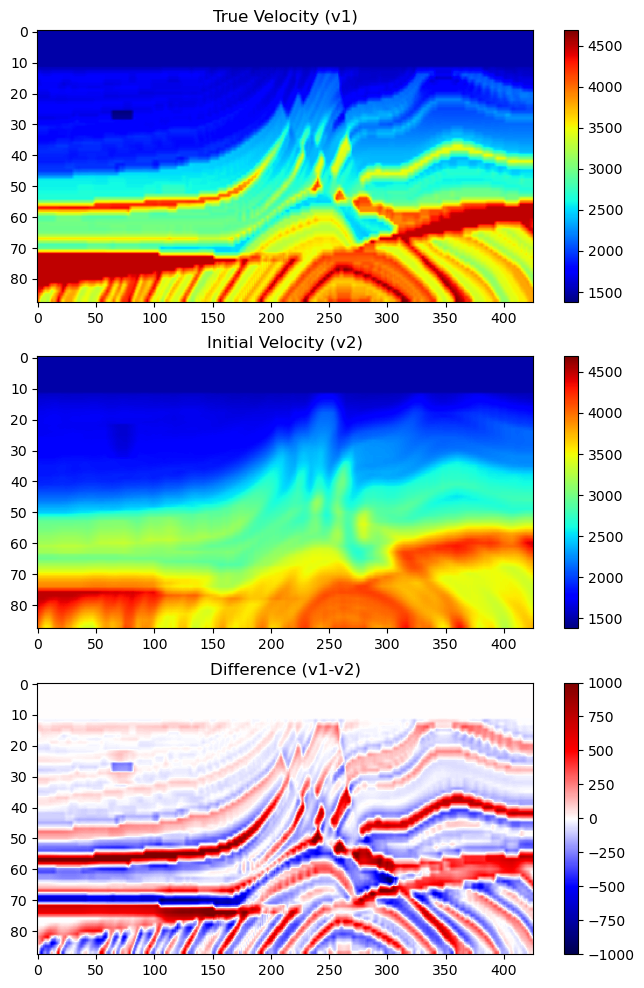

In [8]:
figure(figsize=(8,12))
vmin,vmax = extrema(v1)
dmin,dmax = -1000,1000

subplot(3,1,1); imshow(v1,aspect="auto",cmap="jet"); 
colorbar(); clim(vmin,vmax); title("True Velocity (v1)")

subplot(3,1,2); imshow(v2,aspect="auto",cmap="jet");
colorbar(); clim(vmin,vmax); title("Initial Velocity (v2)");

subplot(3,1,3); imshow(v1.-v2,aspect="auto",cmap="seismic");
colorbar(); clim(dmin,dmax); title("Difference (v1-v2)");

## 2. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster
Note we need to do this because we are using multiple workers on the same physical node, and without setting up thread affinity the modeling will be *incredibly* slow.

Because we set `ENV["OMP_DISPLAY_ENV"] = "true"`, when the "cluster spins up" by calling `addprocs()` below you will see the OMP environment printed out on each worker. You can verify that half of the threads are assigned to the first half of the physical cpus, and similarly for the second half, by looking at the value of the `OMP_PLACES` variable.

In [9]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [10]:
@everywhere using Distributed, DistributedArrays, DistributedJets, Jets, JetPack, WaveFD, JetPackWaveFD, LinearAlgebra, LineSearches, Optim, Random

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '22'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPE

## 3. Create list of shot locations 
We use 16 shot locations.

In [11]:
nshots = 16
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)))
@show nshots;
@show sx;

nshots = 16
sx = [0, 1133, 2267, 3400, 4533, 5667, 6800, 7933, 9067, 10200, 11333, 12467, 13600, 14733, 15867, 17000]


## 4. Build F, the distributed block operator for seismic modeling

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [12]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [13]:
@everywhere begin
    ntrec = 2501
    dtrec = 0.004
    dtmod = 0.002
end

@everywhere function makeF(i,nz,nx,dz,dx,sx)
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=4.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval=0)
end

In [14]:
F = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (88, 426) → (17046816,)"

## 5. Use F to create data for both models

In [15]:
# This may take a while if running on a single node
t1 = @elapsed begin
    d1 = F*v1;
end
@show t1;
t2 = @elapsed begin
    d2 = F*v2;
end
@show t2;

t1 = 46.759458564
t2 = 36.222121828


#### Compute the residual data

In [16]:
r = d1 .- d2;

## 6. Visualize data

#### Collect the data locally before plotting

In [17]:
shots = [1,4,8]
@show shots
d1local = [getblock(d1,i) for i in shots]
d2local = [getblock(d2,i) for i in shots]
r2local = [getblock(r,i) for i in shots]
sxlocal = [sx[i] for i in shots]
@show sxlocal;

shots = [1, 4, 8]
sxlocal = [0, 3400, 7933]


#### Plot shot gathers for true model, initial model, and residual
* We flip the direction of the residual and modeled data in order to help display the match with the true data.

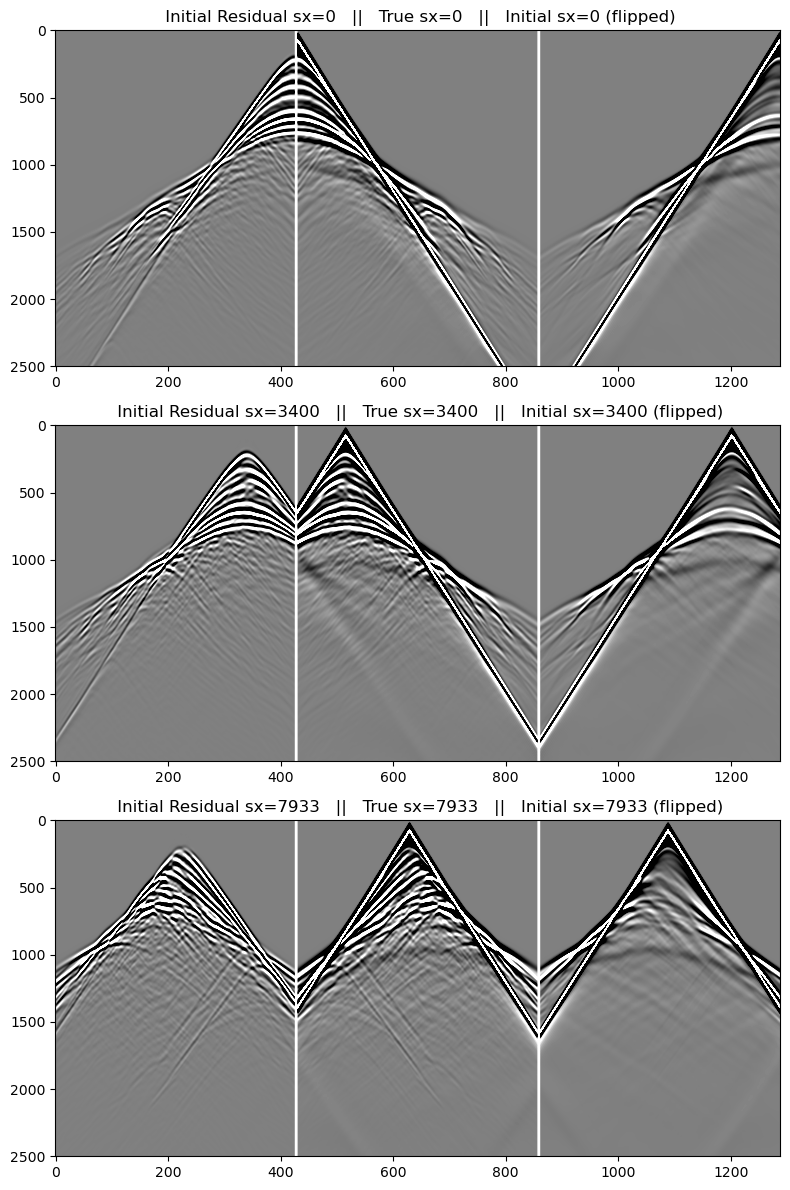

scale = 1.8197385059563265


In [18]:
scale = 10.0 / sqrt(norm(d1)^2 / length(d1))
@show scale

nzero = 5
pad = ones(Float32,ntrec,nzero)
figure(figsize=(8,12)); clf()
for (iplot,ishot) in enumerate(shots)
    cat2 = hcat(reverse(r2local[iplot],dims=2), pad, d1local[iplot], pad, reverse(d2local[iplot],dims=2))
    subplot(3,1,iplot);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sx=$(sx[ishot])   ||   True sx=$(sx[ishot])   ||   Initial sx=$(sx[ishot]) (flipped)");
end
tight_layout()

## 7. Assess if data is cycle skipped at the farthest offsets
Next we plot the far offset traces for these shots to determine if the data is cycle skipped. 

You can see in the plots below that the refraction waveforms (first arrivals) in the initial model are not cycle skipped, so we proceed. 

Note that a very significant part of the residual wavefield is actually reflections in this example.

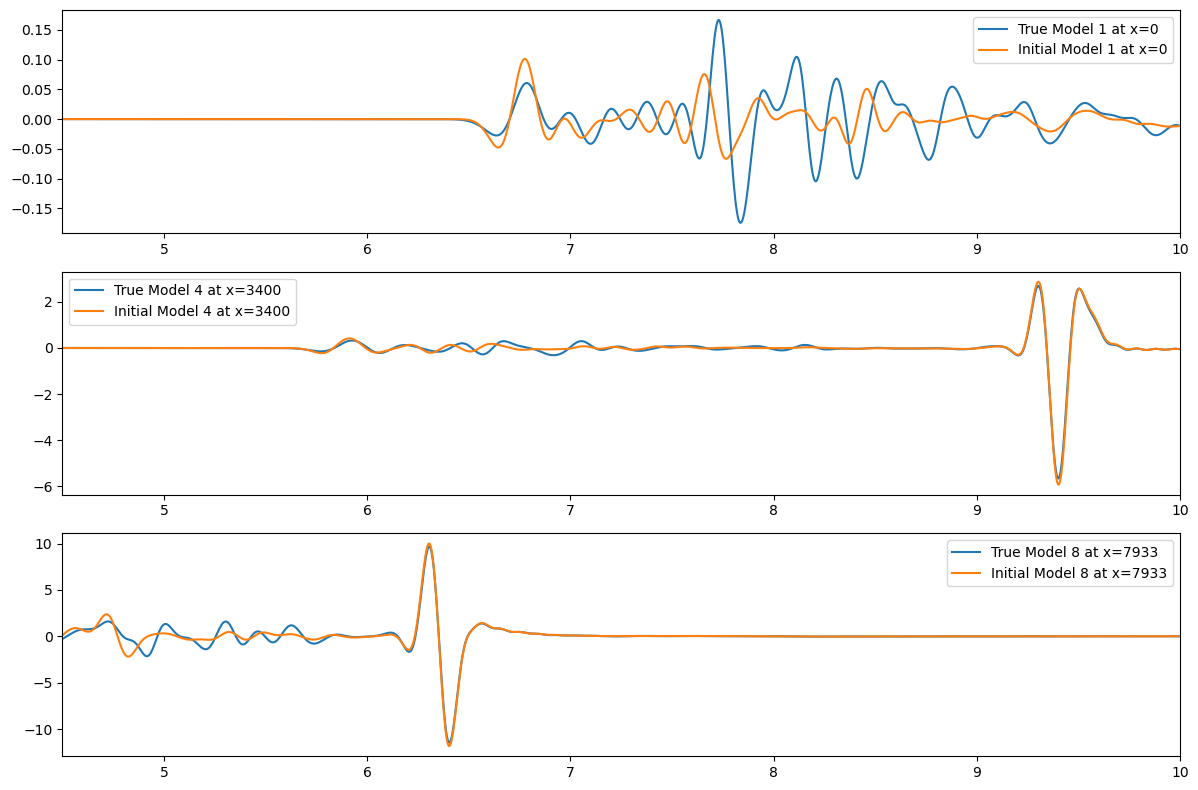

In [19]:
scale = 10.0 / sqrt(norm(d1)^2 / length(d1))
t = [0.0:dtrec:dtrec*(ntrec - 1);]

figure(figsize=(12,8)); clf()
for (iplot,ishot) in enumerate(shots)
    subplot(3,1,iplot);
    plot(t,d1local[iplot][:,end],label="True Model $(ishot) at x=$(sx[ishot])");
    plot(t,d2local[iplot][:,end],label="Initial Model $(ishot) at x=$(sx[ishot])");
    xlim([4.5,t[end]])
    legend()
end
tight_layout()

## 8. Build the gradient and cost functions

#### Build water bottom mask for gradient
We use this mask to remove imprint in gradient very close to the source locations. The mask is set to 0 wherever the true velocity model has value 1500 m/s, and is set to 1 otherwise. 

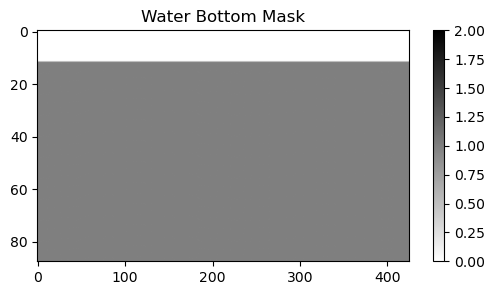

In [20]:
wb_mask = ones(Float32,size(v))
wb_mask[v.==1500.0] .= 0;
figure(figsize=(6,3))
imshow(wb_mask,aspect="auto",cmap="gray_r",clim=[0,+2]);
colorbar();
title("Water Bottom Mask");

#### Gradient function
This method is called by the solver whenever the gradient is required. Steps in computing the gradient are as follows:
1. Compute the source side illumination
1. Establish the illumination compensation preconditioner as `1/illum^2`
1. Apply the adjoint of the Jacobian to the current residual `d - F*v` 
1. Apply very simple scaling based on the size of the first gradient and save to apply to future gradients

In [21]:
function gradient!(G,F,v,dobs,p,wb_mask)
    J = jacobian(F,v)
    s = srcillum(J)
    s .= ((s ./ maximum(s)).^2) .+ 1e-8
    R = JopDiagonal((1 ./ s).^2)
    t = @elapsed begin
        dv = F*v
        G .= R' ∘ J' * (dv .- dobs)
    end
    ϕ = norm(dv .- dobs)
    p.count += 1
    @info @sprintf("%3d g_time; %10.4f (sec) -- g_rms; %10.4e -- cost; %10.4e\n", 
        p.count, t, sqrt(norm(G)^2 / length(G)), ϕ)
    G .*= wb_mask #mute water column
    if p.gscale == 0.0
        # compute scalar from first gradient, apply to future gradients
        p.gscale = 10 ./ maximum(G) 
    end
    G .*= p.gscale
end
# struct to save the first gradient scalar
mutable struct FwiPar
   count::Int64
   gscale::Float64
end
p = FwiPar(0,0.0)
g!(G,x) = gradient!(G,F,x,d1,p,wb_mask)

g! (generic function with 1 method)

#### Compute the initial gradient and display

In [22]:
grad = zeros(Float32,size(v1))
tgrad = @elapsed begin
    g!(grad,v2)
end
@show tgrad;

tgrad = 33.676098022


┌ Info:   1 g_time;    25.7635 (sec) -- g_rms; 2.6493e+05 -- cost; 3.3085e+03
└ @ Main In[21]:12


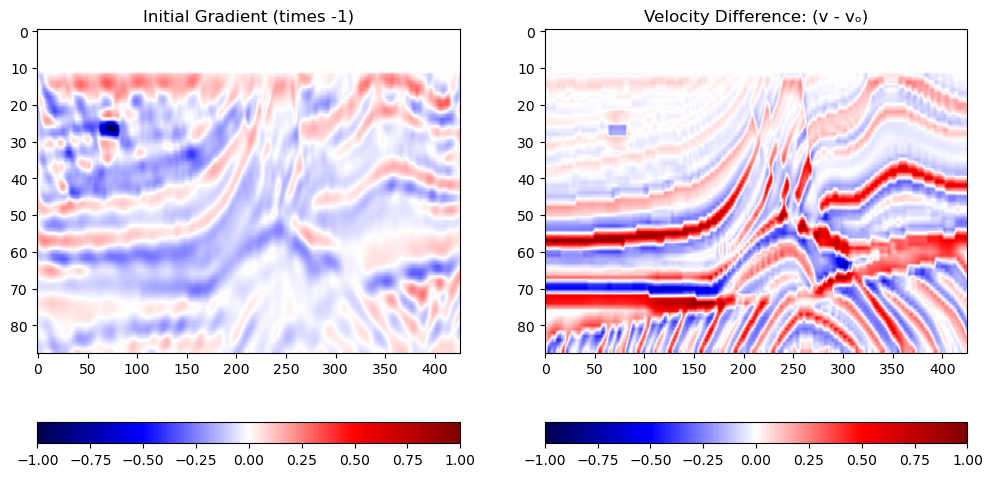

In [23]:
figure(figsize=(12,6))
dv = v1 .- v2
subplot(1,2,1)
imshow(-1 .* grad ./ maximum(abs,grad),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);title("Initial Gradient (times -1)");
subplot(1,2,2)
imshow(dv ./ maximum(abs,dv),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);title("Velocity Difference: (v - vₒ)");

In [24]:
function cost(x,F,d1)
    dx = F*x
    ϕ = norm(d1 .- dx)
    return ϕ
end
f(x) = cost(x,F,d1)

f (generic function with 1 method)

In [25]:
@info "initial cost; $(f(v2))";

┌ Info: initial cost; 3308.454
└ @ Main In[25]:1


## 9. Perform the FWI using optim.jl
We will do 15 iterations of limited memory BFGS. 

In [26]:
niter = 15
solver = LBFGS(m = niter, 
    alphaguess = LineSearches.InitialQuadratic(), 
    linesearch = LineSearches.MoreThuente());

In [27]:
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

In [28]:
p = FwiPar(0,0.0)
redirect_stdout(open("/dev/null","w")) # otherwise the models are printed to stdout at every iteration

topt = @elapsed begin
    result = optimize(f, g!, v2, solver,
        Optim.Options(
            x_tol = eps(Float32),
            f_tol = eps(Float32),
            g_tol = eps(Float32),
            iterations = niter,
            show_trace = true,
            store_trace = true,
            show_every = 1,
            extended_trace = true,
            allow_f_increases = false,
            callback = mycallback))
end

┌ Info:   1 g_time;    21.5326 (sec) -- g_rms; 2.6493e+05 -- cost; 3.3085e+03
└ @ Main In[21]:12
┌ Info: iter=0, cost=3308.454, |grad|=10.000001
└ @ Main In[27]:2
┌ Info:   2 g_time;    19.3829 (sec) -- g_rms; 2.5555e+05 -- cost; 3.2506e+03
└ @ Main In[21]:12
┌ Info:   3 g_time;    21.6994 (sec) -- g_rms; 2.2389e+05 -- cost; 3.0385e+03
└ @ Main In[21]:12
┌ Info:   4 g_time;    22.1896 (sec) -- g_rms; 2.2389e+05 -- cost; 3.0385e+03
└ @ Main In[21]:12
┌ Info: iter=1, cost=3038.5122, |grad|=8.323763
└ @ Main In[27]:2
┌ Info:   5 g_time;    22.4237 (sec) -- g_rms; 2.6837e+05 -- cost; 2.3966e+03
└ @ Main In[21]:12
┌ Info: iter=2, cost=2396.6018, |grad|=30.184284
└ @ Main In[27]:2
┌ Info:   6 g_time;    22.4525 (sec) -- g_rms; 2.3554e+05 -- cost; 2.2857e+03
└ @ Main In[21]:12
┌ Info: iter=3, cost=2285.683, |grad|=19.564959
└ @ Main In[27]:2
┌ Info:   7 g_time;    22.1625 (sec) -- g_rms; 2.2249e+05 -- cost; 2.2334e+03
└ @ Main In[21]:12
┌ Info:   8 g_time;    22.6692 (sec) -- g_rms; 1.8141e+0

3094.50093988

In [29]:
@printf("Time for optimization; %.2f minutes\n", topt / 60)

In [30]:
vf = Optim.minimizer(result) # optimal solution
ϕ = Optim.f_trace(result)    # cost vs iteration
m = Optim.x_trace(result);   # model vs iteration

## 10. Visualize velocity models and objection function

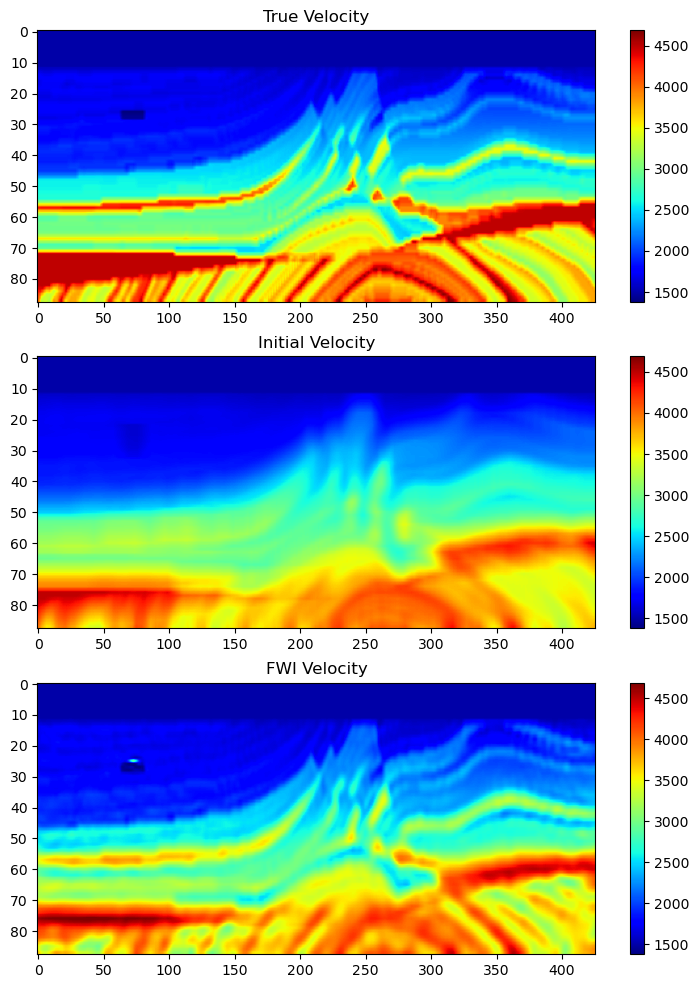

In [31]:
figure(figsize=(9,12)); clf()

subplot(3,1,1);imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("True Velocity")

subplot(3,1,2);imshow(v2,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("Initial Velocity");

subplot(3,1,3);imshow(vf,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI Velocity");

#### Display the velocity difference models 

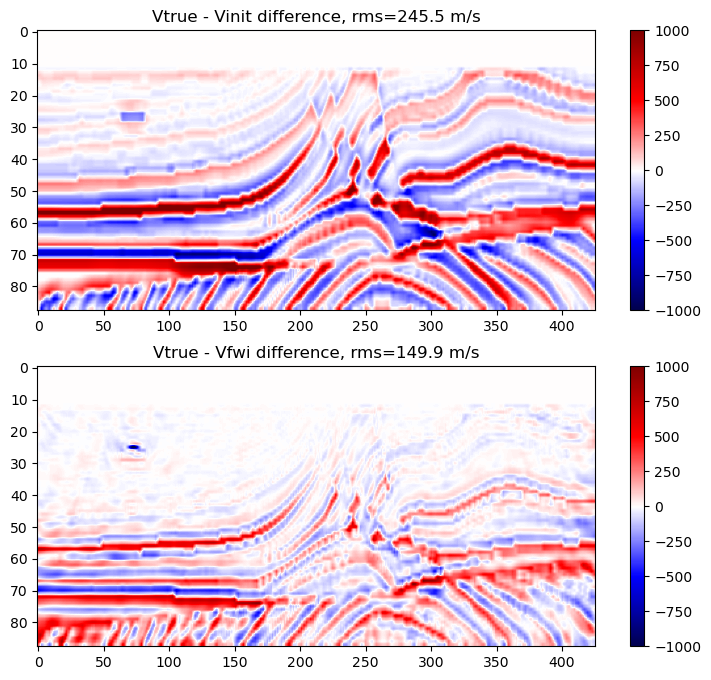

In [32]:
rms_v2 = @sprintf("%.1f m/s", sqrt(norm(v1 .- v2)^2 / length(v1)))
rms_vf = @sprintf("%.1f m/s", sqrt(norm(v1 .- vf)^2 / length(v1)))

figure(figsize=(9,8)); clf()

subplot(2,1,1);imshow(v1 .- v2,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vinit difference, rms=$(rms_v2)");

subplot(2,1,2);imshow(v1 .- vf,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vfwi difference, rms=$(rms_vf)");


#### Display the cost function 

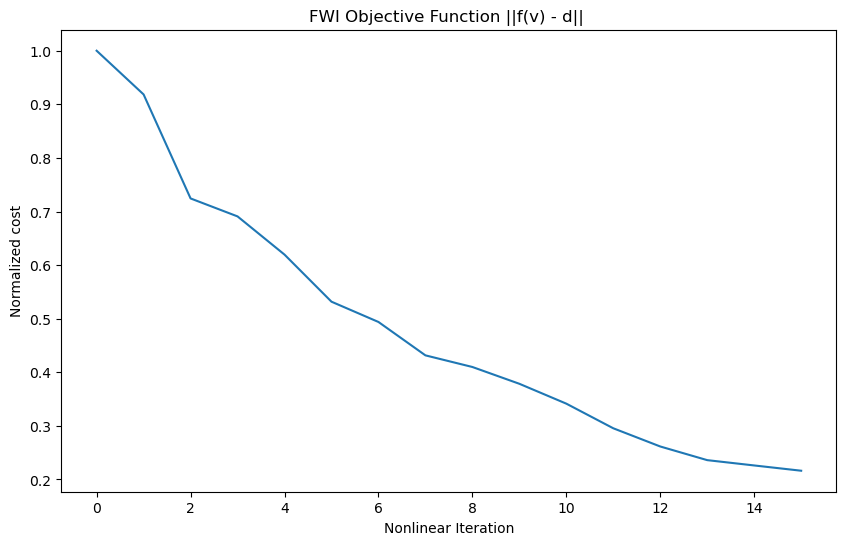

In [33]:
figure(figsize=(10,6)); clf()
iters = [0:1:niter;]
plot(iters, ϕ ./ ϕ[1])
xlabel("Nonlinear Iteration")
ylabel("Normalized cost")
title("FWI Objective Function ||f(v) - d|| ");

## 11. Visualize data match
#### Generate data in the FWI velocity model

In [34]:
tf = @elapsed begin
    df = F*vf;
end
@show tf;

#### Compute residuals and collect gathers for display

In [35]:
rf = d1 .- df;
dflocal = [getblock(df,i) for i in shots];
rflocal = [getblock(rf,i) for i in shots];

#### Plot shot gathers for true, initial model, and fwi models
* We flip the direction of the residual and modeled data in order to help display the match with the true data.
* We also show the initial model panels from above for easier comparison with the FWI panel.
* We first make a function to create the plots that we can re-use

In [36]:
function make_plot(index)
    figure(figsize=(8,8)); clf()
    cat2 = hcat(reverse(r2local[index],dims=2), pad, d1local[index], pad, reverse(d2local[index],dims=2))
    catf = hcat(reverse(rflocal[index],dims=2), pad, d1local[index], pad, reverse(dflocal[index],dims=2))
    subplot(2,1,1);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sx=$(sx[index])   ||   True sx=$(sx[index])   ||   Initial sx=$(sx[index]) (flipped)");
    subplot(2,1,2);
    imshow(catf,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" FWI Residual sx=$(sx[index])   ||   True sx=$(sx[index])   ||   FWI sx=$(sx[index]) (flipped)");
    tight_layout()
end

make_plot (generic function with 1 method)

#### Data for the 1st shot, generated in the initial and FWI models

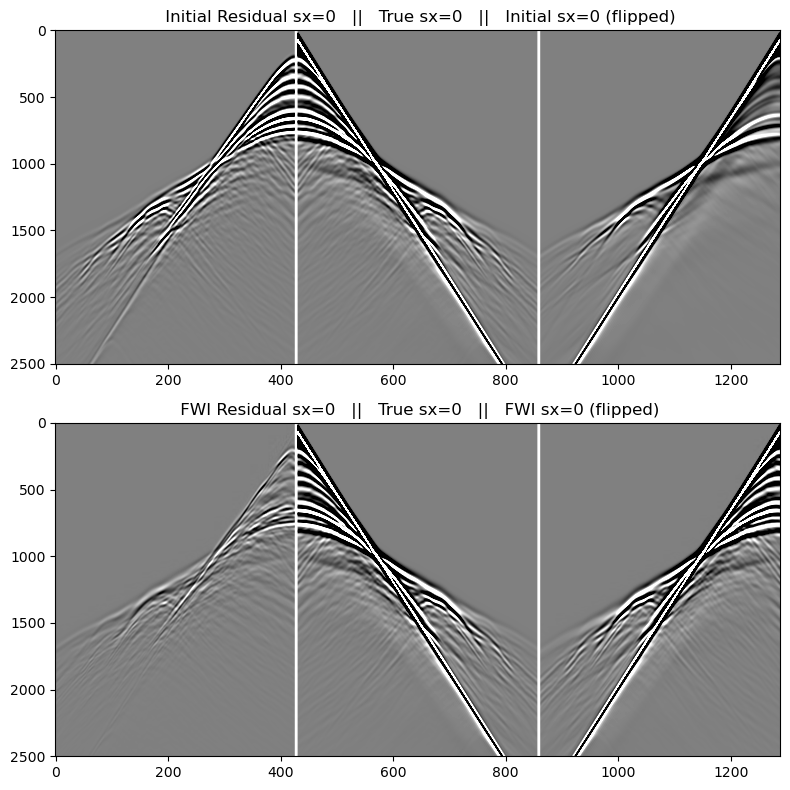

In [37]:
make_plot(1)

#### Data for the 4th shot, generated in the initial and FWI models

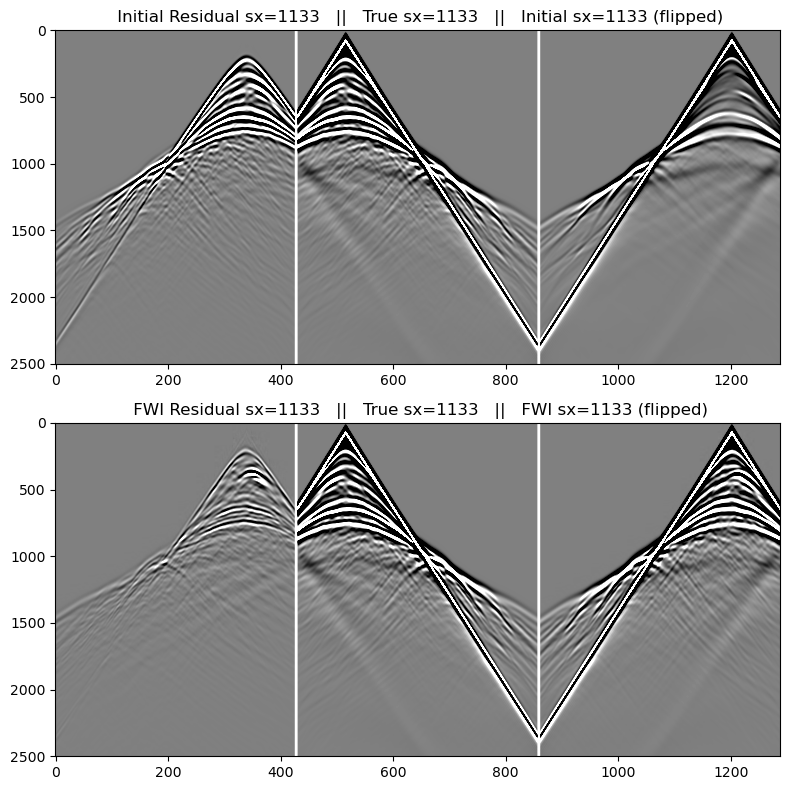

In [38]:
make_plot(2)

#### Data for the 8th shot, generated in the initial and FWI models

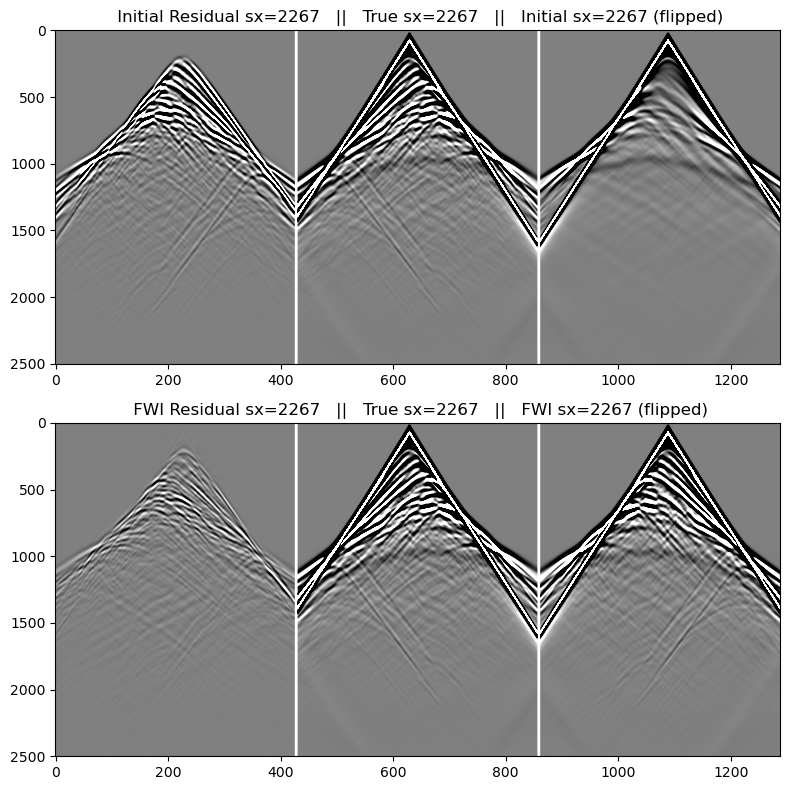

In [39]:
make_plot(3)

## 11. Write models to local disk

#### Interpolate models to 10m for subsequent RTM  

In [40]:
@printf("nz,nx,dz,dx; %5d %5d %12.4f %12.4f\n", nz, nx, dz, dx)

z1,z2 = 0.0,dz*(nz-1)
x1,x2 = 0.0,dx*(nx-1)

dz2,dx2 = 10.0,10.0
nz2 = floor(Int,z2/dz2) + 1
nx2 = floor(Int,x2/dx2) + 1

dom = JetSpace(Float32,size(vf)...)
rng = JetSpace(Float32,nz2,nx2)
op = JopInterp(dom, rng)

v1_resamp = op * v1;
v2_resamp = op * v2;
vf_resamp = op * vf;

#### Plot resampled models

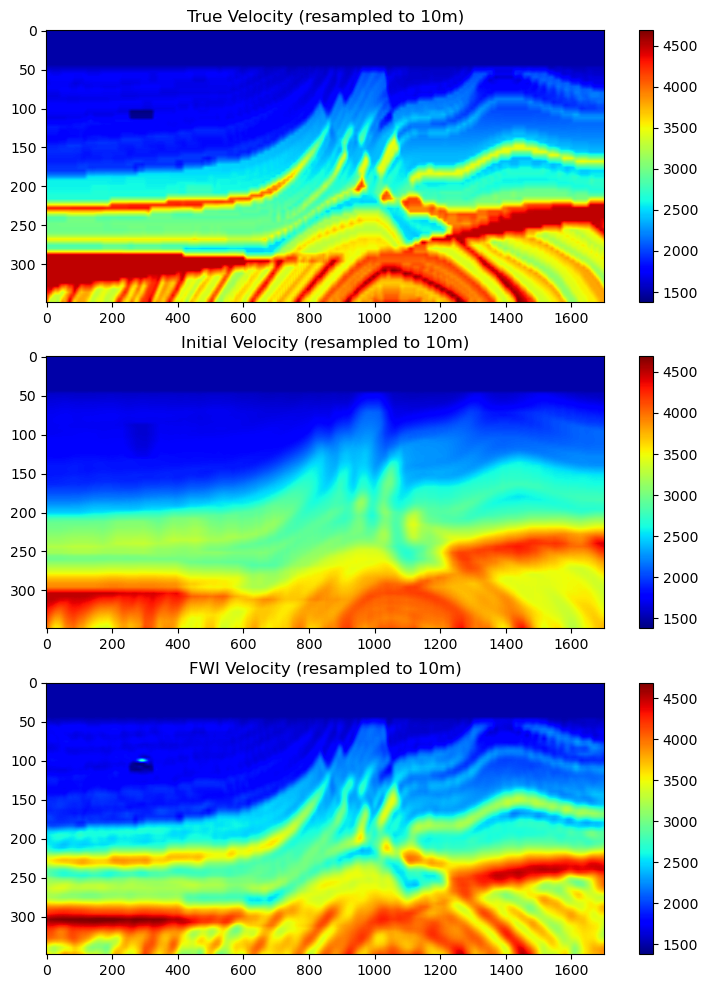

In [41]:
figure(figsize=(9,12)); clf()

subplot(3,1,1);imshow(v1_resamp,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("True Velocity (resampled to 10m)")

subplot(3,1,2);imshow(v2_resamp,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("Initial Velocity (resampled to 10m)");

subplot(3,1,3);imshow(vf_resamp,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("FWI Velocity (resampled to 10m)");

#### Write out the models 

In [42]:
file1 = @sprintf("marmousi_resampled_10m_%dx%d_vtrue.bin", nz2, nx2);
file2 = @sprintf("marmousi_resampled_10m_%dx%d_vinit.bin", nz2, nx2);
filef = @sprintf("marmousi_resampled_10m_%dx%d_vfwi.bin", nz2, nx2);

write(file1,v1_resamp);
write(file2,v2_resamp);
write(filef,vf_resamp);

## 12. Remove local files and workers

In [43]:
close(F)
rmprocs(workers())

Task (done) @0x00007f4b6e75a980

## Record time at end of notebook
Report total elapsed time to run the notebook

In [44]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; -0.18 minutes\n"